
**<h1 align='center'>Time Series Forecasting</h1>**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Group Members** 

---
### 1.   Blessed Mutengwa - R182565F
### 2.   Rufaro Nyandoro - R1710732
### 3.   Laika Ali - R178492M
---







In [ ]:
!pip install simplejson 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 130 kB 4.8 MB/s 


In [ ]:
!pip install fastquant

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.9 MB 4.9 MB/s 
     |████████████████████████████████| 1.5 MB 46.2 MB/s 
     |████████████████████████████████| 3.0 MB 31.6 MB/s 
     |████████████████████████████████| 410 kB 47.9 MB/s 
     |████████████████████████████████| 199 kB 45.9 MB/s 
     |████████████████████████████████| 128 kB 44.4 MB/s 
     |████████████████████████████████| 138 kB 17.4 MB/s 
     |████████████████████████████████| 1.4 MB 43.9 MB/s 
     |████████████████████████████████| 9.5 MB 6.3 MB/s 
     |████████████████████████████████| 6.4 MB 33.6 MB/s 
     |████████████████████████████████| 843 kB 30.4 MB/s 
     |████████████████████████████████| 96 kB 2.9 MB/s 
     |████████████████████████████████| 4.0 MB 31.9 MB/s 
     |████████████████████████████████| 271 kB 42.5 MB/s 
     |████████████████████████████████| 1.1 MB 44.6 MB/s 
     |█████████████████████████████

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import pandas as pd
import pandas_datareader as web
from fastquant import get_crypto_data
import datetime as dt
from tensorflow import keras

from keras.models import model_from_json
import os.path

import math
import simplejson

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential 

# Constants

In [ ]:
crypto_currency = 'BTC'
base_currency = 'USD'

prediction_days = 60

start_date = "2016-01-01"
end_date = dt.datetime.strftime(dt.datetime.now(), "%Y-%m-%d")

# Data Acquisation

In [ ]:
def get_train_data():
  data = get_crypto_data(f'{crypto_currency}/{base_currency}T', start_date, end_date)
  scaler = MinMaxScaler(feature_range=(0,1))
  scaled_data = scaler.fit_transform(data['close'].values.reshape(-1,1))

  x_train, y_train = [], []

  for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

  x_train, y_train = np.array(x_train), np.array(y_train)
  x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

  return data, scaler, x_train, y_train

In [ ]:
def get_test_data():
  data = get_train_data()[0]
  scaler = get_train_data()[1]
  test_start = "2018-01-01"
  test_end = dt.datetime.strftime(dt.datetime.now(), "%Y-%m-%d")
  test_data = get_crypto_data(f'{crypto_currency}/{base_currency}T', test_start, test_end)
  actual_values = test_data['close'].values
  scaler = MinMaxScaler(feature_range=(0,1))
  scaled_data = scaler.fit_transform(actual_values.reshape(-1,1))
  total_data = pd.concat((data['close'], test_data['close']), axis=0)
  model_inputs = total_data[len(total_data)-len(test_data)-prediction_days:].values
  model_inputs = model_inputs.reshape(-1,1)
  model_inputs = scaler.fit_transform(model_inputs)

  x_test, y_test = [], []

  for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])
    y_test.append(model_inputs[x, 0])

  x_test, y_test = np.array(x_test), np.array(y_test)
  x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

  pred_dates = total_data.index.values[-(len(x_test)):]
  return x_test, pred_dates, actual_values, model_inputs, x_test, y_test

# Data Preprocessing

In [ ]:
data = get_train_data()[0]

In [ ]:
data

,open,high,low,close,volume
dt,,,,,
2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377
2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264
2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763
2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022
2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060
...,...,...,...,...,...
2022-05-25,29654.58,30223.74,29294.21,29542.15,59537.386590
2022-05-26,29542.14,29886.64,28019.56,29201.35,94581.654630
2022-05-27,29201.35,29397.66,28282.90,28629.80,90998.520100


In [ ]:
data.info() # Check for Non-Null Count if dataframe has missing values

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1747 entries, 2017-08-17 to 2022-05-29
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1747 non-null   float64
 1   high    1747 non-null   float64
 2   low     1747 non-null   float64
 3   close   1747 non-null   float64
 4   volume  1747 non-null   float64
dtypes: float64(5)
memory usage: 81.9 KB


In [ ]:
data.isna().sum()/len(data)*100 #  count the percentage of missing values for each column

open      0.0
high      0.0
low       0.0
close     0.0
volume    0.0
dtype: float64

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['close'].values.reshape(-1,1))

# Build Model

In [ ]:
def create_model():
  x_train = get_train_data()[2]
  y_train = get_train_data()[3]
  model = Sequential()
  model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
  model.add(Dropout(0.2))
  model.add(LSTM(units=50, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(units=50))
  model.add(Dropout(0.2))
  model.add(Dense(units=1))
  return model

In [ ]:
def loss_plot(x):
  plt.plot(x['loss'], label='loss', color='g')
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('epoch')
  plt.legend(loc='upper left')
  plt.show()

In [ ]:
def mae_mse(x):
  plt.plot(x['mse'], label='mse', color='r')
  plt.plot(x['mae'], label='mae', color='b')
  plt.title('MAE vs MSE')
  plt.ylabel('MSE/MAE')
  plt.xlabel('epoch')
  plt.legend(loc='upper left')
  plt.show()

In [ ]:
def train_model():
  pass
  # return model, history

In [ ]:
def load_trained_model():
  with open('/content/drive/MyDrive/Colab Notebooks/trained_models/time_series_model_2021.json', 'r') as json_file:
    model = model_from_json(json_file.read())

    # load weights into new model
    model.load_weights("/content/drive/MyDrive/Colab Notebooks/trained_models/time_series_model_2021.h5")
  return model

In [ ]:
if os.path.exists('/content/drive/MyDrive/Colab Notebooks/trained_models/time_series_model_2021.h5'):
    print('loading Trained Model')
    print('***************************************************************************************')
    model = load_trained_model()
    print('Successfully Loaded Time Series Saved Model...')
else:
    print('training new model...\nInit training...')
    print('model training started')
    print('***************************************************************************************')
    x_test = get_test_data()[4]
    y_test = get_test_data()[5]
    x_train = get_train_data()[2]
    y_train = get_train_data()[3]

    model = create_model()

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])
    history = model.fit(x_train, y_train, epochs=20, batch_size=32) 

    model_score = model.evaluate(x_train, y_train, 
                                verbose=1)


    testPredict = model.predict(x_test, batch_size=35)

    TM_MSE = model_score
    rmse = mean_squared_error(y_test, testPredict , squared=False)
    # print(f'Mean squared error (MSE) : {TM_MSE}')
    print(f'Root Mean squared error (RMSE) : {rmse}')

    # Save trained model
    model_json = model.to_json()
    with open("/content/drive/MyDrive/Colab Notebooks/trained_models/time_series_model_2021.json", "w") as json_file:
      json_file.write(simplejson.dumps(simplejson.loads(model_json), indent=4))

    # serialize weights to HDF5
    model.save_weights('/content/drive/MyDrive/Colab Notebooks/trained_models/time_series_model_2021.h5')
    print("Finished training Time Series Model and has been saved to disk...")

loading Trained Model
***************************************************************************************
Successfully Loaded Time Series Saved Model...


In [ ]:
try:
  loss_plot(history.history)
except NameError:
  pass

In [ ]:
try: 
  mae_mse(history.history)
except NameError:
  pass

In [ ]:
def model_summary():
  summary = model.summary()
  return summary

In [ ]:
def time_series_predictions():
  scaler = get_train_data()[1]
  prediction = model.predict(get_test_data()[0])
  prediction = scaler.inverse_transform(prediction)
  return prediction


In [ ]:
def plot_predictions():
  dates = get_test_data()[1]
  plt.figure(figsize = (20,10))
  plt.plot(dates,get_test_data()[2]+60, color = 'g', label='Actual Prices')
  plt.plot(dates,time_series_predictions(), color='r', label='Predicted Prices')
  plt.title(f'{crypto_currency} Price Prediction')
  plt.xlabel('Time')
  plt.ylabel('Price')
  plt.legend(loc='upper left')
  plt.show()

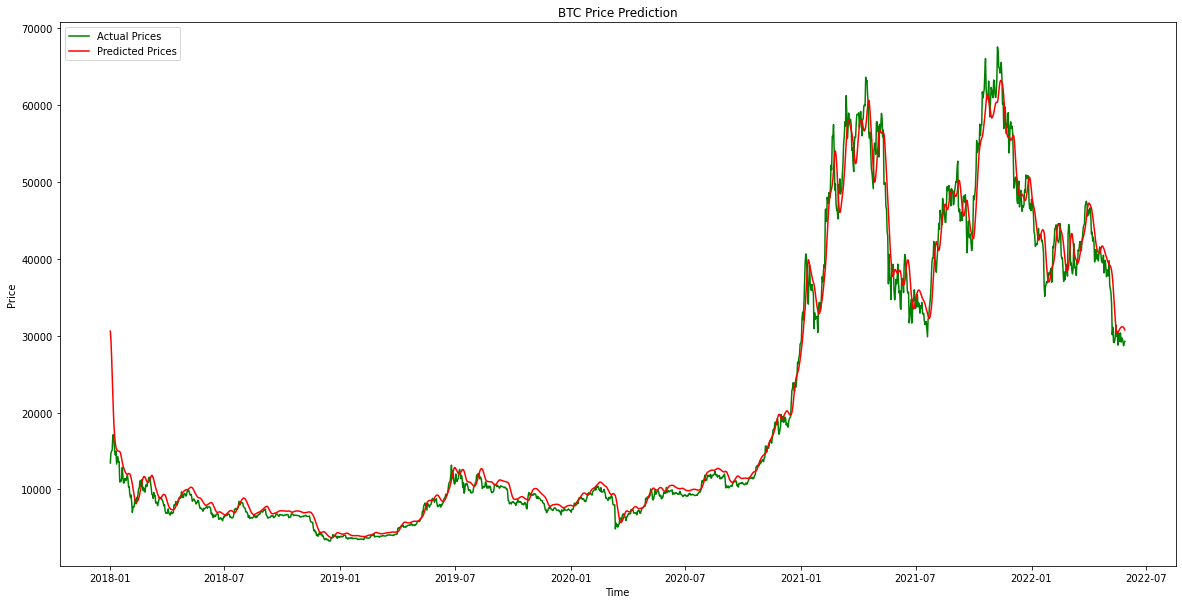

In [ ]:
plot_predictions()

**Predict Next Day**

In [ ]:
get_test_data()[2] + 60

array([13440.  , 14735.11, 14979.51, ..., 28689.8 , 29091.33, 29295.89])

In [ ]:
def pred_for_next_day():
  model_inputs = get_test_data()[3]
  scaler = get_train_data()[1]
  x_test = get_test_data()[4]
  r_data = [model_inputs[len(model_inputs)+ 2 - prediction_days:len(model_inputs)+2,0]]
  r_data = np.array(r_data)
  r_data = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

  pred = model.predict(r_data)
  pred = scaler.inverse_transform(pred)
  return pred[-1][0]

In [ ]:
-+print(f"Tomorrow's Bitcoin price predictation is estimated at ${pred_for_next_day():.2f}.")

Tomorrow's Bitcoin price predictation is estimated at $30748.99.
